In [ ]:
#For Kaggle
#date=''

#For WL data
source='WL'
date='20241118'

saveImage=False

packageName='07-sklearn.ensemble.b-boosting'
classifierName='4-GradientBoostingClassifier'
extraParameterName='3-Random undersampling'

print('done')

In [ ]:
import sys
import os
from importlib import reload
fpath = os.path.join('..//scripts')
sys.path.append(fpath)

import warnings
warnings.filterwarnings('ignore')

#loading internal scripts
import frauddetection as fd
import sourcedata as sd
import dataimport as di
import result as resultMd
import sampling as sp
reload(fd)
reload(sd)
reload(di)
reload(resultMd)
reload(sp)

print('done')

In [ ]:
# Hyperparameters Results

learning_rateFound=0.05
n_estimatorsFound=473
max_depthFound=1


resultMd.update_hyperparameter_config_result(packageName,classifierName,extraParameterName,max_depthFound,n_estimatorsFound)

print('done')

In [ ]:
import pandas as pd

dfTrx0 = pd.read_csv('../data/cleaned/'+source+'export'+date+'.csv')
predictors = fd.getPredictors(dfTrx0)
dfTrx=fd.getStandardScaledData('export'+date+'.csv',source,predictors)
dfTrx.head(5)

In [ ]:
from sklearn.model_selection import train_test_split

predictors = fd.getPredictors(dfTrx0)
TEST_SIZE = 0.20 # test size using_train_test_split
RANDOM_STATE = 0
x_train0, x_test, y_train0, y_test = train_test_split(dfTrx[predictors], dfTrx['Class'], test_size = TEST_SIZE, 
                                                        stratify= dfTrx['Class'],
                                                        random_state = RANDOM_STATE)

x_train, y_train = sp.randomUnderSampling(x_train0, y_train0,1/100)

# Hyperparameters tuning

In [ ]:
%%script false

from scipy.stats import randint
from sklearn.ensemble import GradientBoostingClassifier
 
modelClf = GradientBoostingClassifier(random_state=42)
dic_param={
    'learning_rate': [0.1], 
    'n_estimators': randint(70,140),
    'max_depth':randint(6,14)
}

res=fd.hyperparameterSelectionRandomizedSearchCVSampling(modelClf, dic_param, 'f1', x_train, y_train, iter=4)
print(res)


In [ ]:
%%script false
from sklearn.ensemble import GradientBoostingClassifier
 
modelClf = GradientBoostingClassifier(random_state=42)

dic_param={
    'learning_rate': [0.05], 
    'n_estimators': [472,473,474],
    'max_depth': [1]
}
res=fd.hyperparameterSelectionGridSearchCVSampling(modelClf, dic_param, 'f1', x_train, y_train)
print(res)

#{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 450}
#0.2883700740195628
#scoref1 0.2988980716253444

#{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 500}
#0.28838602352630044
#scoref1 0.29924502402196296

#{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 470}
#0.28956256573837036
#scoref1 0.29945054945054944

#{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 480}
#0.28956808300521064
#scoref1 0.29945054945054944

#{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 475}
#0.2897776295562206
#scoref1 0.29945054945054944

#{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 473}
#0.2897776295562206
#scoref1 0.29945054945054944



# Final validation

In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
 
modelClf = GradientBoostingClassifier(random_state=42)
parameters={'learning_rate': learning_rateFound, 'n_estimators':n_estimatorsFound, 'max_depth':max_depthFound}
modelClf.set_params(**parameters)
modelClf.fit(x_train, y_train)

predsTrain = modelClf.predict(x_train)
predsTest = modelClf.predict(x_test)

f1Train=fd.print_scores(y_train, predsTrain,'f1', False)
f1Test=fd.print_scores(y_test, predsTest,'f1')
fd.show_importance(modelClf, predictors)
fd.show_confusion_matrix(y_test, predsTest)
fd.show_prediction_graph(modelClf, x_test,y_test)

diffF1=f1Train-f1Test
print("diffF1",diffF1)

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': modelClf.feature_importances_})
val=tmp[(tmp['Feature']=='amountBin')]['Feature importance']
amountImportance =val.values[0]
print("amount importance",amountImportance)

test-set confusion matrix:
 [[1065363    1709]
 [   1100     270]]
accuracy score: 0.9974
balanced accuracy score: 0.5977
recall score: 0.1971
precision score: 0.1364
f1 score: 0.1612
mcc score: 0.1627
roc auc score: 0.5977


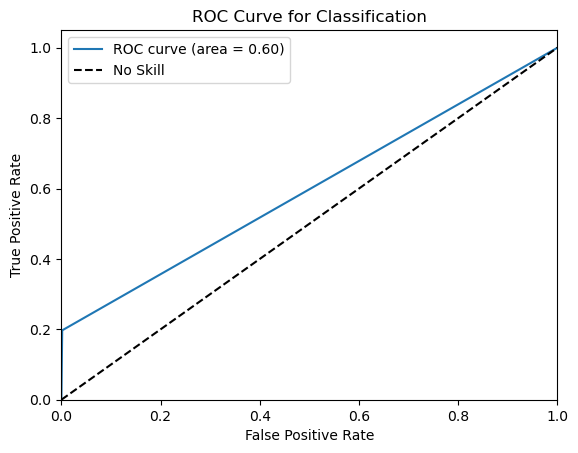

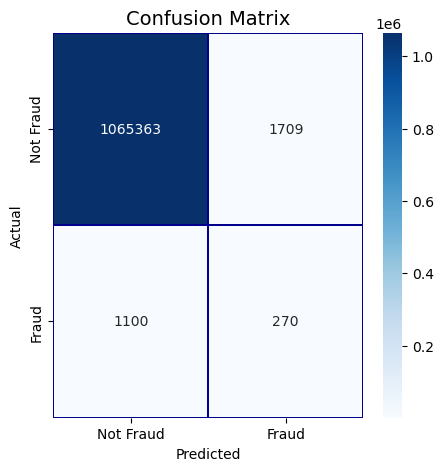

export20241121.csv



KeyboardInterrupt



In [61]:
files = fd.getAllFiles()
predictors = fd.getPredictors(dfTrx0)

range = []
f1s = []
rocs = []
loop =0
for file in files:
    loop=loop+1
    range.append(loop)
    print(file)
  
    dfTrx=fd.getStandardScaledData(file,source,predictors)
    preds = modelClf.predict(dfTrx[predictors])

    f1,mcc,roc= fd.print_scores(dfTrx['Class'], preds,'All', True)
    #fd.show_importance(modelClf,predictors)
    fd.show_confusion_matrix(dfTrx['Class'], preds)
    f1s.append(f1)
    rocs.append(roc)

fd.plt_train_test(range, f1s)
resultMd.update_performance_nextdays_result(packageName,classifierName,extraParameterName, f1s[0],f1s[1],f1s[2],f1s[3],rocs[0],rocs[1],rocs[2],rocs[3],diffF1,amountImportance)
